## Assignment 8 Submission

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import stats

### Q1

In Q1, the diabetes dataset is used for predicting whether the patients have diabetes or not. The data is taken from kaggle (https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset).

In [ ]:
df = pd.read_csv("./../diabetes_prediction_dataset.csv")

# Cleaning the dataset
df = df.drop(["smoking_history"], axis = 1)
df["gender"] = pd.factorize(df["gender"])[0] # 0 female, 1 male, 2 other

# Rescaling, otherwise the sample won't converged
df["age"] = (df["age"]-df["age"].mean()) / df["age"].std()
df["bmi"] = (df["bmi"]-df["bmi"].mean()) / df["bmi"].std()
df["HbA1c_level"] = (df["HbA1c_level"]-df["HbA1c_level"].mean()) / df["HbA1c_level"].std()
df["blood_glucose_level"] = (df["blood_glucose_level"]-df["blood_glucose_level"].mean()) / df["blood_glucose_level"].std()

df.head()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1.692695,0,1,-0.321054,1.001701,0.047704,0
1,0,0.538004,0,0,-0.000116,1.001701,-1.426203,0
2,1,-0.616688,0,0,-0.000116,0.161107,0.489876,0
3,0,-0.261398,0,0,-0.583229,-0.492688,0.416181,0
4,1,1.515050,1,1,-1.081965,-0.679486,0.416181,0


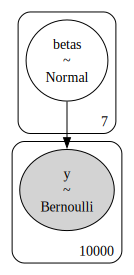

In [ ]:
df = df.sample(frac = 0.1) # 100k data is too big
y_obs = df["diabetes"].to_numpy() # output

df2 = df.drop("diabetes", axis = 1)
X = df2.to_numpy()
n, p = len(X), len(X[0])

with pm.Model() as bayes_logit:
    betas = pm.Normal("betas", mu = 0, sigma = 1, shape = p)
    y = pm.Bernoulli("y", p = pm.math.sigmoid(X@betas), observed = y_obs)
pm.model_to_graphviz(bayes_logit)

In [91]:
with bayes_logit:
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


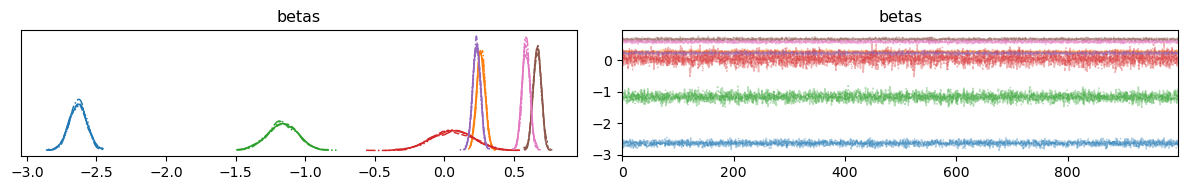

In [92]:
az.plot_trace(idata)
plt.tight_layout()

In [93]:
az.summary(idata, round_to = 5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],-2.63340,0.06254,-2.74897,-2.51558,0.00092,0.00065,4566.47841,3423.76934,1.00084
betas[1],0.26241,0.02932,0.20445,0.31415,0.00045,0.00032,4262.98929,3106.17417,0.99953
betas[2],-1.16447,0.10866,-1.36763,-0.95785,0.00154,0.00109,4971.64901,3451.06339,0.99983
betas[3],0.05722,0.14719,-0.21740,0.32992,0.00229,0.00204,4140.53712,3164.41393,1.00051
betas[4],0.23053,0.02792,0.17560,0.28145,0.00039,0.00028,5059.52536,3223.26896,1.00000
betas[5],0.66668,0.02863,0.61502,0.72048,0.00044,0.00031,4255.88044,3170.04287,1.00087
betas[6],0.58570,0.02769,0.53014,0.63458,0.00038,0.00027,5182.15685,3292.22357,1.00107


<Axes: >

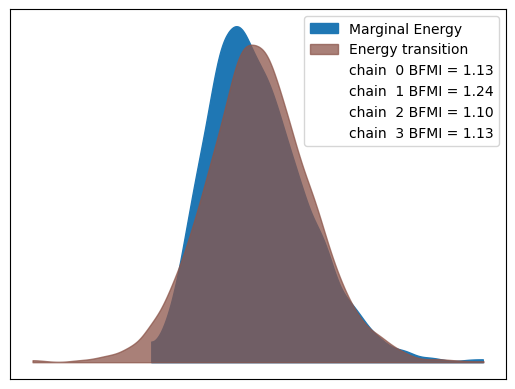

In [94]:
az.plot_energy(idata)

From the data, we use many features to predict the probability of having diabetes by using Bayesian logisitic regression. The code indicates that we removed some features out for simplicity, and only took 1% of the entire for faster computation. Therefore, the sample may not be the most accurate ones. Moreover, the data need to be rescaled so that the sample converged.

From the MCMC result summary, we can see that the regression coefficients are all significant to the model $\frac{\hat \beta_i}{se(\beta_i)}$ yields very high values except `beta[3]` (heart_disease column). The lower bound and upper bound of credible interval does not differ that much, indicates that the sample converge well with more than 4000 ESS, which is higher than the number of sample itself.

From the energy plot, the energy transition graph is slightly off the marginal energy graph. This indicates that there are some samples among the chain that might not agree with each other. This may happen because there are very few positive data (patients having diabetes) and we only pick 1% of them (which may not have any positive value in the worst case).

### Q2

In Q2, the energy efficient dataset is used, the dataset is obtained from the features of different building and the heating load and cooling load as outputs (https://www.kaggle.com/datasets/elikplim/eergy-efficiency-dataset). We will use last $m$ columns to be an output

In [46]:
df_full = pd.read_csv("./../ENB2012_data.csv")
for col in df_full.columns:
    df_full[col] = (df_full[col] - df_full[col].mean()) / df_full[col].std()
df_full.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-1.340767,-1.7593,-1.813393,-0.669680,-0.342443
1,2.040447,-1.784712,-0.561586,-1.469119,0.999349,-0.446922,-1.7593,-1.813393,-0.669680,-0.342443
2,2.040447,-1.784712,-0.561586,-1.469119,0.999349,0.446922,-1.7593,-1.813393,-0.669680,-0.342443
3,2.040447,-1.784712,-0.561586,-1.469119,0.999349,1.340767,-1.7593,-1.813393,-0.669680,-0.342443
4,1.284142,-1.228438,0.000000,-1.197897,0.999349,-1.340767,-1.7593,-1.813393,-0.145409,0.388113


In [ ]:
df = df_full.sample(n = 100)
X = df.iloc[:, :8].to_numpy()
Y = df.iloc[:, 8:]
n, m, p = len(df), 10-len(X[0]), len(X[0])

(100, 2, 8)

In [ ]:
# A wrap-up function from the given code for comparing different value of n, m, p
def MVN_reg(n, m, p):
    df = df_full.sample(n = n)
    X = df.iloc[:, :p].to_numpy()
    Y = df.iloc[:, p:]
    beta_ = np.ones((p,m))
    a_cov = Y.cov().to_numpy()
    Y = Y.to_numpy()

    with pm.Model() as MNV_LKJ:
        
        packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                    sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                    compute_corr=False)
        L = pm.expand_packed_triangular(m, packed_L)
        betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
        Sigma = pm.Deterministic('Sigma', L.dot(L.T))
        y = pm.MvNormal('y', mu=X@betas, chol=L,  #cov=Sigma
                        observed=Y)   
        
        idata = pm.sample()

    az.plot_trace(idata,var_names='betas')
    fig,ax = plt.subplots(1,5,figsize=(18,4))
    ax[-1].imshow(a_cov)
    ax[0].set_title(("Sigma used to generate y"))
    for chain in range(4):
        ax[chain].imshow(idata.posterior['Sigma'].mean(axis=1)[chain])
        ax[chain].set_title(("chain",chain,"mean Sigma"))

We will test the different value of $(n, m, p)$:
1. $n = 100, \ m = 2, \ p = 8$
2. $n = 30, \ m = 2, \ p = 8$
3. $n = 100, \ m = 4, \ p = 6$

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 332 seconds.


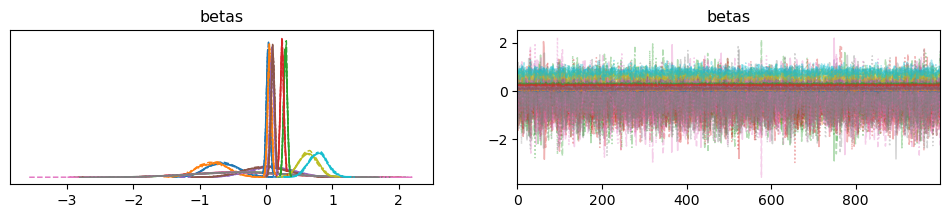

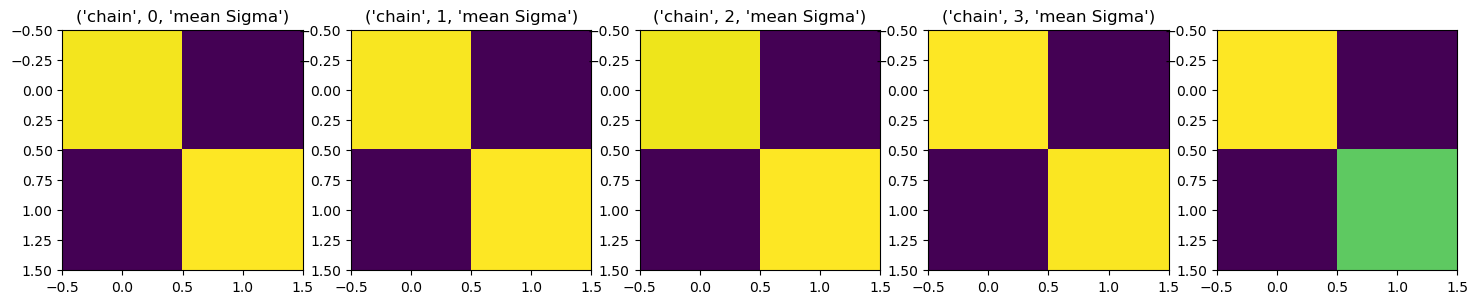

In [52]:
MVN_reg(100, 2, 8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


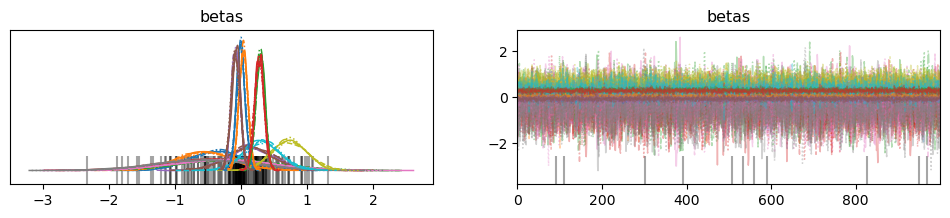

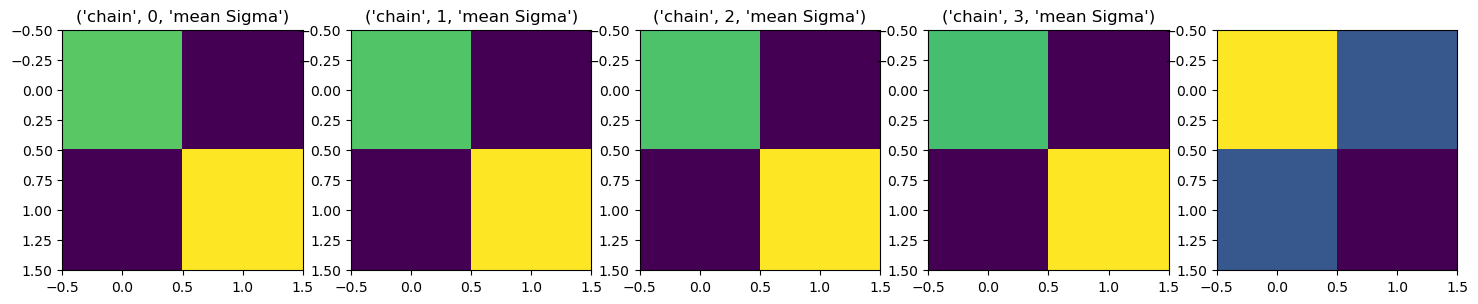

In [53]:
MVN_reg(30, 2, 8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 367 seconds.


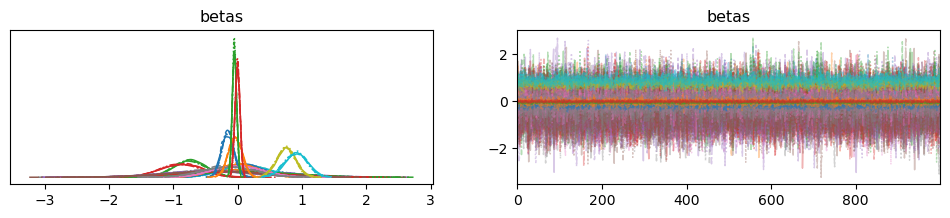

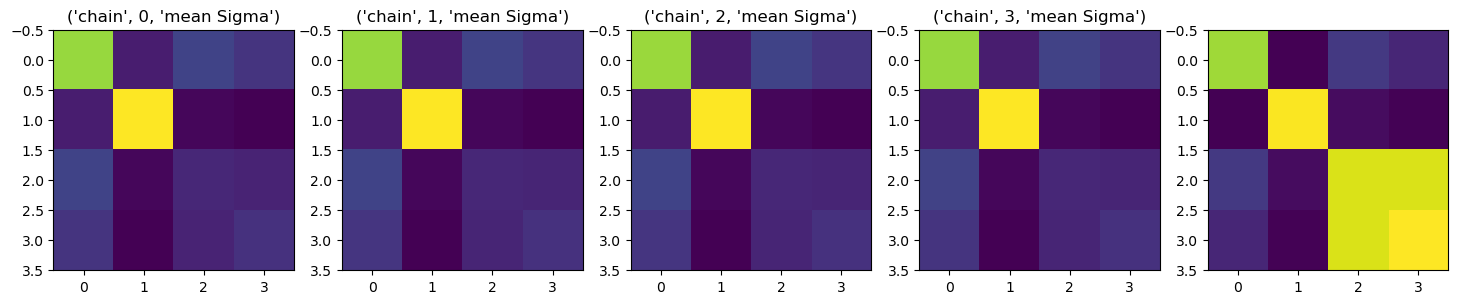

In [54]:
MVN_reg(100, 4, 6)

From the original dataset, the data has 768 entries and we downsample the data to $n = 100$ and $n = 30$. Comparing the size of $n$ alone, we can see that the larger the sample, the better MCMC sample and more accurate inference, as we can see from the covariance matrix that the $n = 100$ sample has more accurate posterior covariance matrix (and some divergence sample in $n = 30$).

For the impact of $m, p$, we can see that increasing $m$ might make the posterior covariance matrix not accurate on the last 2 outputs, which are used as the only outputs in previous sampling. This problem may arise from the dataset value itself, where some features are used as outputs instead which constitute no correlation with other outputs at all.

For the sampling from MCMC, there are some value of $\beta$ that are significant (very tight curve in the trace plot), and some are not. There may be some divergences in small value of $n$, but overall the chains yields satisfying results, and produce the same results among the chains.

### Q3

The dataset used in Q3 are adapted from https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification/data?select=train.csv, which contains the data about mobile price.

In [101]:
df_full = pd.read_csv("./../train.csv")
df_full.head()

,battery_power,clock_speed,dual_sim,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,four_g,touch_screen,wifi,price_range
0,842,2.2,0,1,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,0.5,1,0,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,0.5,1,2,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,2.5,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,0,0,0,2
4,1821,1.2,0,13,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [ ]:
# Convert some columns into binary and rescaling the data
df_full["price_range"] = (df_full["price_range"] > 2).astype(int)
for i, col in enumerate(df_full.columns):
    if i != 2 and i < 15:
        df_full[col] = (df_full[col] - df_full[col].mean()) / df_full[col].std()
df_full.head()

,battery_power,clock_speed,dual_sim,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,four_g,touch_screen,wifi,price_range
0,-0.902372,0.830572,0,-0.762304,-1.380298,0.340654,1.348911,-1.101696,-1.305424,-1.408596,-1.146497,0.391605,-0.784787,0.283032,1.462128,0,0,1,0
1,-0.495015,-1.252751,1,-0.992642,1.154735,0.687376,-0.120029,-0.664602,-0.645827,0.585631,1.704039,0.467200,1.113987,-0.635158,-0.734084,1,1,0,0
2,-1.537302,-1.252751,1,-0.531966,0.493422,1.380820,0.134210,0.209587,-0.645827,1.392336,1.074699,0.441387,-0.310094,-0.864705,-0.368048,1,1,0,0
3,-1.418964,1.198217,0,-0.992642,-1.214970,1.034098,-0.261274,0.646681,-0.151130,1.286428,1.236662,0.594421,0.876640,0.512579,-0.002013,0,0,0,0
4,1.325574,-0.394912,0,2.001753,0.658751,0.340654,0.021215,-1.101696,0.673365,1.268401,-0.091429,-0.657502,-1.022134,-0.864705,0.730057,1,1,0,0


In [134]:
# Like Q2, combine the given code into one single function for comparison
def probit_reg(n, m, p):
    df = df_full.sample(n = n)
    beta_ = np.ones((p, m))
    X = df.iloc[:, :p].to_numpy()
    Y = df.iloc[:, (19-m):]
    a_cor = Y.corr().to_numpy()
    Y = Y.to_numpy()
    
    with pm.Model() as GLM:
        
        L,R,std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                    sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                    compute_corr=True)
        #L = pm.expand_packed_triangular(m, packed_L)
        betas = pm.Normal('betas', mu=0, sigma=1, shape=(p,m))
        #Sigma = pm.Deterministic('Sigma', L.dot(L.T))
        z = pm.MvNormal('z', mu=X@betas, cov=R) #cov=Sigma
        # the probit is the inverse cdf of a standard normal
        # the inverse probit is the cdf of a standard normal
        y = pm.Bernoulli('y', p=pm.math.invprobit(z), observed=Y)   
        # Integrating out z would give:
        #y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)   
        
        idata = pm.sample()
    
    az.plot_trace(idata, var_names = "betas")
    fig,ax = plt.subplots(2,4,figsize=(18,8))
    ax[0,0].imshow(a_cor)
    ax[0,0].set_title(("Correlation of the raw data y"))
    for i in range(m):
        for j in range(m):
            ax[0,0].text(i,j,str(round(a_cor[j,i],2)),
                        c='w', ha='center', va='center')
    ax[0,1].imshow(np.cov(Y.T))
    ax[0,1].set_title(("Raw binary data covariance"))
    for i in range(m):
        for j in range(m):
            ax[0,1].text(i,j,str(round(np.cov(Y.T)[j,i],2)),
                        c='w', ha='center', va='center')
    ax[0,2].imshow(np.cov((Y-stats.norm().cdf(X@beta_)).T))
    ax[0,2].set_title(("Binary residual covariance"))
    for chain in range(4):
        ax[1,chain].imshow(idata.posterior['R_corr'].mean(axis=1)[chain])
        for i in range(m):
            for j in range(m):
                ax[1,chain].text(i,j,str(round(idata.posterior['R_corr'].mean(axis=1)[chain].values[j,i],2)),
                                c='w', ha='center', va='center')
        ax[1,chain].set_title(("chian",chain,"mean R"))

We will test the different value of $(n, m, p)$ to determine the most suitable combination:
1. $n = 100, \ m = 4, \ p = 15$
2. $n = 50, \ m = 4, \ p = 15$
3. $n = 100, \ m = 2, \ p = 15$
4. $n = 100, \ m = 2, \ p = 8$

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 350 seconds.
There were 1874 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


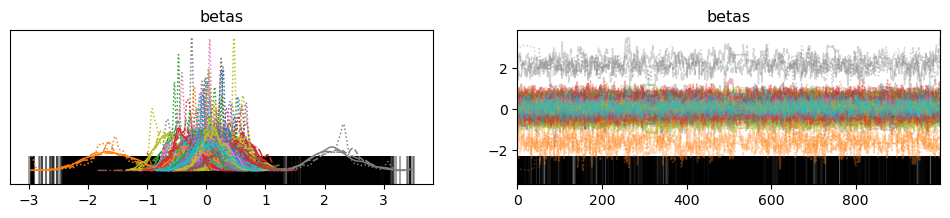

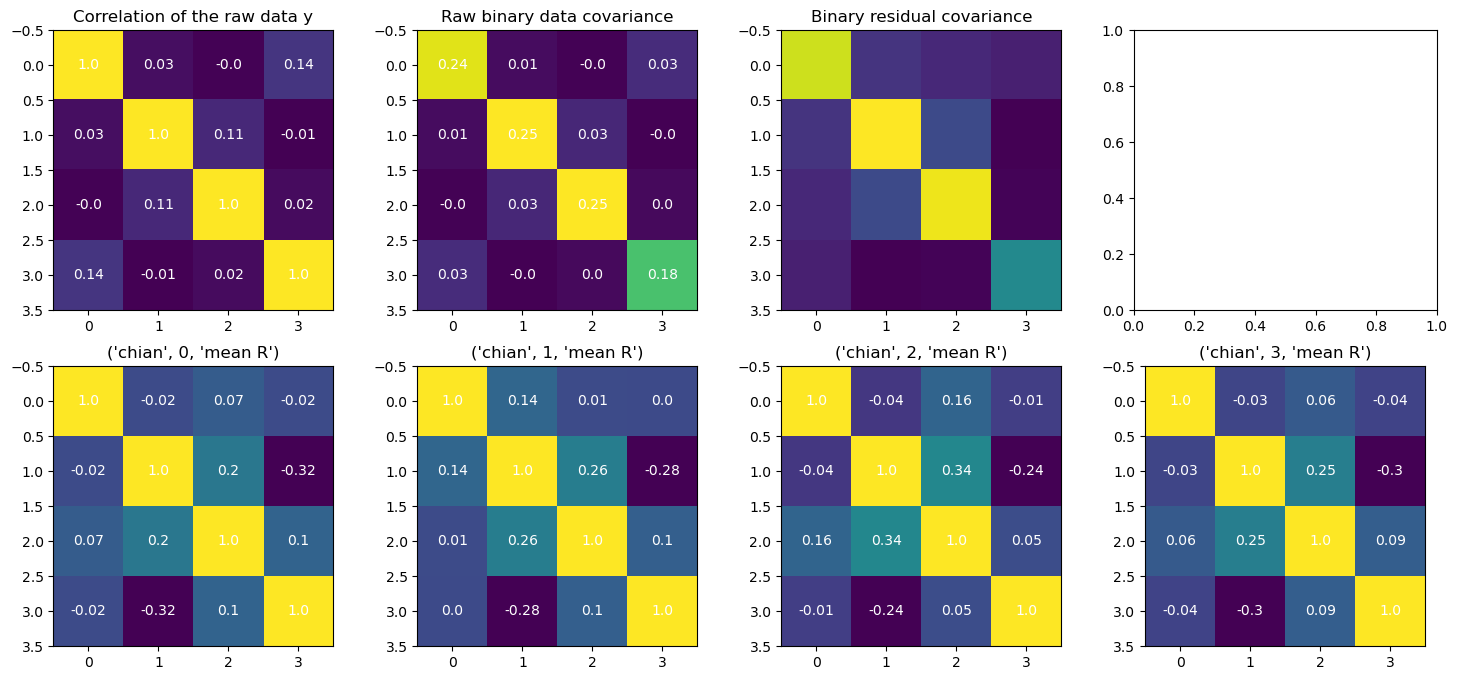

In [135]:
probit_reg(100, 4, 15)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 214 seconds.
There were 3400 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


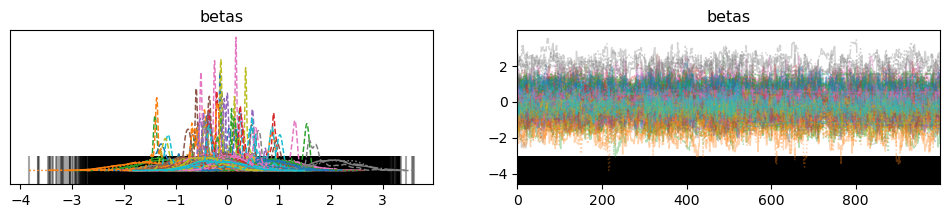

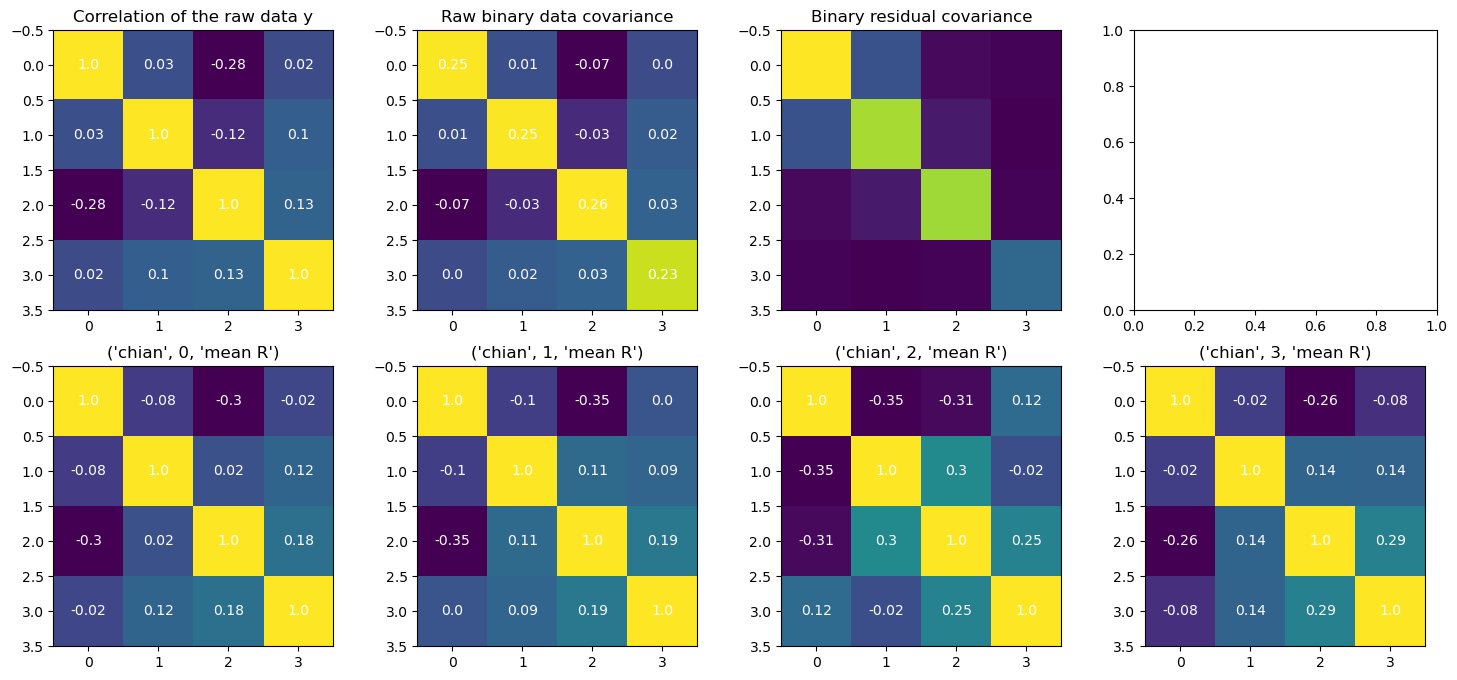

In [136]:
probit_reg(50, 4, 15)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 168 seconds.
There were 1964 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


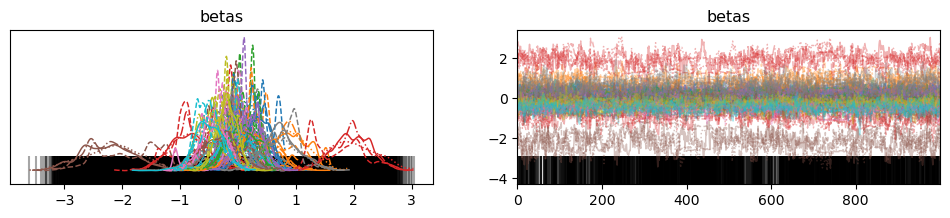

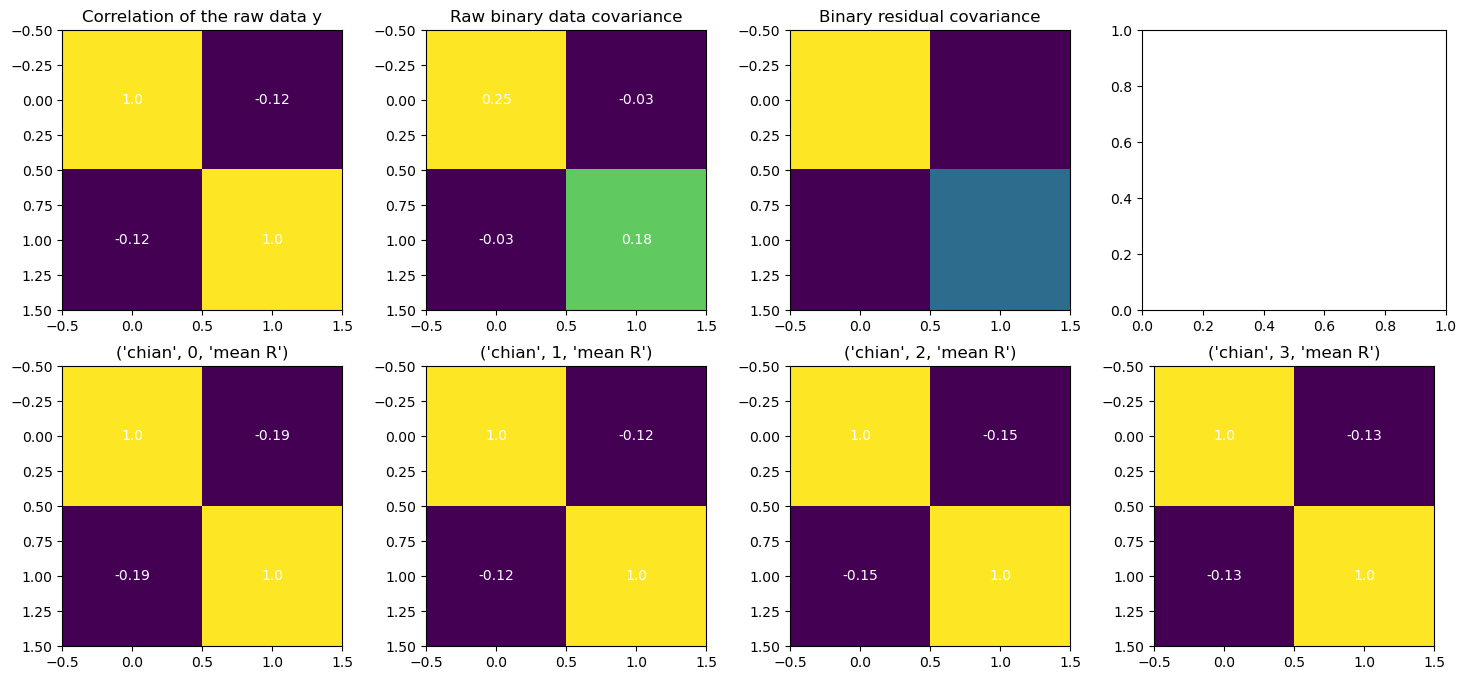

In [139]:
probit_reg(100, 2, 15)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R, betas, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.
There were 1405 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


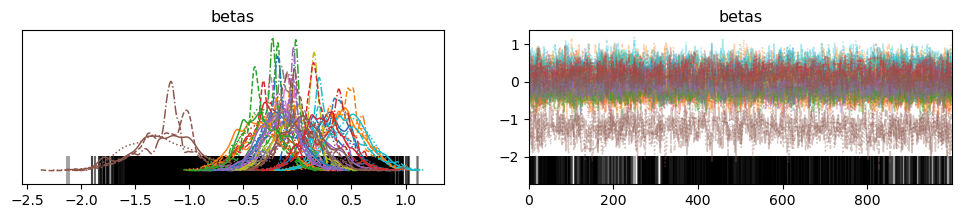

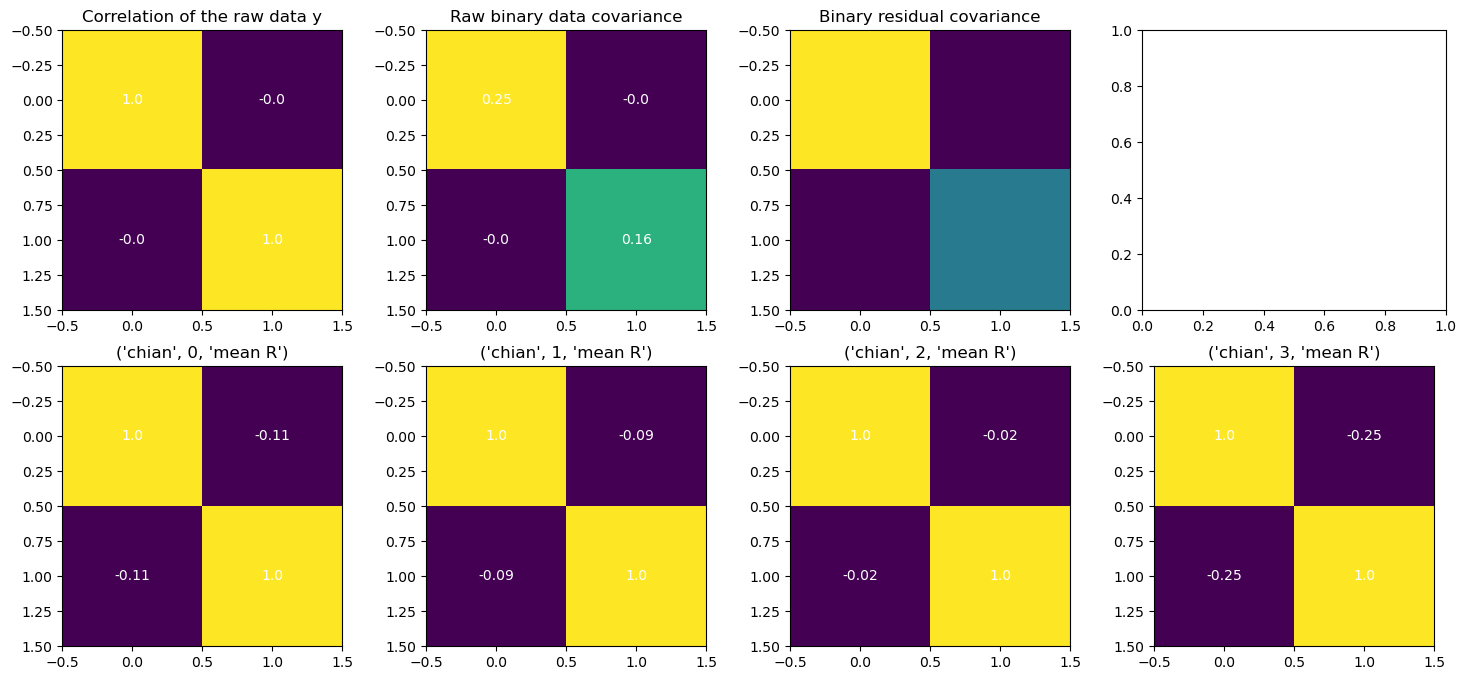

In [138]:
probit_reg(100, 2, 8)

When we changing the value of $n$, we can see that the sampling performs horribly as we can see from 3400 (out of 4000) divergences occurred. The cause of this problem is that we have 15 features to put in, but the sample size is only 50, which makes the MCMC samples extremely inconsistent.

Initially we perform sampling on 4 different binary outputs, which also have a lot of divergences samples. This problem can be addressed by decreasing the number of outputs, reducing from $m=4$ to $m=2$ will yield less divergence and more accurate posterior correlation matrix.

As discussed about the concern of the value of $n$ and $p$, we decrease the number of features $p$ down to only 8 features. We can see that the result has less divergence samples, and have quite accurate posterior correlation matrix (only in some chains, because there are too many divergence samples to make the chains agreeing with each other).